In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

## 1.Data Prepretion

In [127]:
fact = pd.read_csv("FactInternetSales.csv")
product = pd.read_csv("DimProduct.csv" )
subcategory = pd.read_csv("DimProductSubcategory.csv" )
category = pd.read_csv("DimProductCategory.csv")
date = pd.read_csv("DimDate.csv")

In [128]:
df = fact.merge(product, on="ProductKey", how="left") \
         .merge(subcategory, on="ProductSubcategoryKey", how="left") \
         .merge(category, on="ProductCategoryKey", how="left") \
         .merge(date, left_on="OrderDateKey", right_on="DateKey", how="left")
         
df.head()

,ProductKey,OrderDateKey,DueDateKey,ShipDateKey,CustomerKey,PromotionKey,CurrencyKey,SalesTerritoryKey,SalesOrderNumber,SalesOrderLineNumber,...,DayNumberOfYear,WeekNumberOfYear,MonthName,MonthNumberOfYear,CalendarQuarter,CalendarYear,CalendarSemester,FiscalQuarter,FiscalYear,FiscalSemester
0,310,20101229,20110110,20110105,21768,1,19,6,SO43697,1,...,363,53,December,12,4,2010,2,2,2011,1
1,346,20101229,20110110,20110105,28389,1,39,7,SO43698,1,...,363,53,December,12,4,2010,2,2,2011,1
2,346,20101229,20110110,20110105,25863,1,100,1,SO43699,1,...,363,53,December,12,4,2010,2,2,2011,1
3,336,20101229,20110110,20110105,14501,1,100,4,SO43700,1,...,363,53,December,12,4,2010,2,2,2011,1
4,346,20101229,20110110,20110105,11003,1,6,9,SO43701,1,...,363,53,December,12,4,2010,2,2,2011,1


In [129]:
columns_needed = [
    # Sales info
    "SalesOrderNumber",
    "SalesOrderLineNumber",
    "CustomerKey",
    "OrderQuantity",
    "UnitPrice",
    "ExtendedAmount",
    
    # Product info
    "ProductName",
    "ProductSubcategoryKey",
    "ProductSubcategoryName",
    "ProductCategoryKey",
    "ProductCategoryName",
    
    # Date info
    "FullDateAlternateKey",   # YYYY-MM-DD
    "CalendarYear",
    "MonthName",
]

df = df[columns_needed]

In [130]:
df["FullDateAlternateKey"] = pd.to_datetime(df["FullDateAlternateKey"], format="%Y-%m-%d")

In [131]:
df.isnull().sum()

SalesOrderNumber          0
SalesOrderLineNumber      0
CustomerKey               0
OrderQuantity             0
UnitPrice                 0
ExtendedAmount            0
ProductName               0
ProductSubcategoryKey     0
ProductSubcategoryName    0
ProductCategoryKey        0
ProductCategoryName       0
FullDateAlternateKey      0
CalendarYear              0
MonthName                 0
dtype: int64

In [132]:
df.duplicated().sum()

0

## 2.EDA

In [133]:
df.shape

(60398, 14)

In [134]:
# Summary statistics:Number of Orders, Customers, Products
n_orders = df["SalesOrderNumber"].nunique()
n_customers = df["CustomerKey"].nunique()
n_products = df["ProductName"].nunique()

print("Orders:", n_orders)
print("Customers:", n_customers)
print("Products:", n_products)

Orders: 27659
Customers: 18484
Products: 47


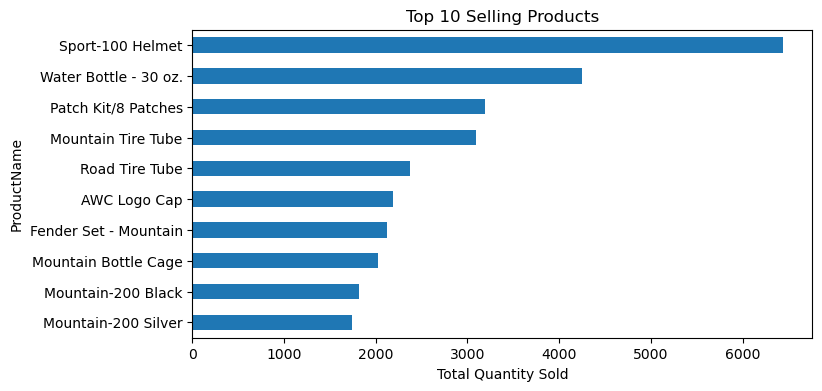

In [135]:
#Top-Selling Products
top_products = (
    df.groupby("ProductName")["OrderQuantity"]
      .sum()
      .sort_values(ascending=False)
      .head(10)
)
# Plot
plt.figure(figsize=(8,4))
top_products.sort_values().plot(kind='barh')
plt.title("Top 10 Selling Products")
plt.xlabel("Total Quantity Sold")
plt.show()

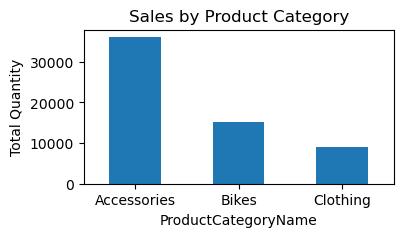

In [136]:
# Performance by Product Category
top_categories = (
    df.groupby("ProductCategoryName")["OrderQuantity"]
      .sum()
      .sort_values(ascending=False)
)

plt.figure(figsize=(4,2))
top_categories.plot(kind='bar', rot=0)
plt.title("Sales by Product Category")
plt.ylabel("Total Quantity")
plt.show()

In [137]:
# Distribution of Items per Order
items_per_order = (
    df.groupby("SalesOrderNumber")["ProductName"]
      .nunique()
)
print("\nAverage unique items per order:", items_per_order.mean())


Average unique items per order: 2.18366535304964


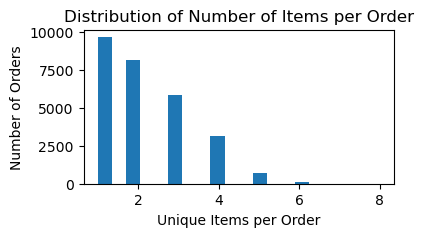

In [138]:
plt.figure(figsize=(4,2))
items_per_order.plot(kind='hist', bins=20)
plt.title("Distribution of Number of Items per Order")
plt.xlabel("Unique Items per Order")
plt.ylabel("Number of Orders")
plt.show() 

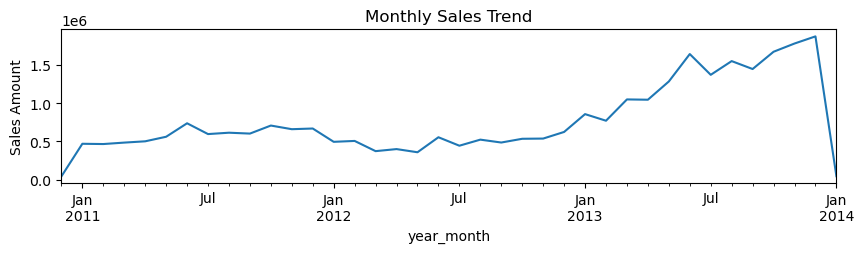

In [139]:
# Monthly Sales Trend
df["year_month"] = df["FullDateAlternateKey"].dt.to_period("M")

monthly_sales = (
    df.groupby("year_month")["ExtendedAmount"]
      .sum()
)

plt.figure(figsize=(10,2))
monthly_sales.plot()
plt.title("Monthly Sales Trend")
plt.ylabel("Sales Amount")
plt.show()

## 3.Basket Preparation

In [140]:
# Create a list of products for each order
basket_df = (
    df.groupby("SalesOrderNumber")["ProductName"]
      .apply(list)
      .reset_index()
)

basket_df.head()

,SalesOrderNumber,ProductName
0,SO43697,[Road-150 Red]
1,SO43698,[Mountain-100 Silver]
2,SO43699,[Mountain-100 Silver]
3,SO43700,[Road-650 Black]
4,SO43701,[Mountain-100 Silver]


In [141]:
#Basket Cleaning: Remove duplicates
basket_df["ProductList"] = basket_df["ProductName"].apply(lambda x: list(set(x)))


In [142]:
#Basket Quality
basket_df["ItemCount"] = basket_df["ProductList"].apply(len)
basket_df["ItemCount"].describe()

count    27659.000000
mean         2.183665
std          1.134096
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          8.000000
Name: ItemCount, dtype: float64

In [143]:
# One-Hot Encoding
te = TransactionEncoder()
te_array = te.fit(basket_df["ProductList"]).transform(basket_df["ProductList"])
basket_ohe = pd.DataFrame(te_array, columns=te.columns_)

basket_ohe = basket_ohe.replace({True: 1, False: 0})
basket_ohe.head()

C:\Users\MSI-Laptop\AppData\Local\Temp\ipykernel_15280\2447452188.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  basket_ohe = basket_ohe.replace({True: 1, False: 0})


,AWC Logo Cap,All-Purpose Bike Stand,Bike Wash - Dissolver,Classic Vest,Fender Set - Mountain,HL Mountain Tire,HL Road Tire,Half-Finger Gloves,Hitch Rack - 4-Bike,Hydration Pack - 70 oz.,...,Sport-100 Helmet,Touring Tire,Touring Tire Tube,Touring-1000 Blue,Touring-1000 Yellow,Touring-2000 Blue,Touring-3000 Blue,Touring-3000 Yellow,Water Bottle - 30 oz.,Women's Mountain Shorts
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 4.Apriori

In [144]:
# Frequent Itemsets
frequent_itemsets = apriori(
    basket_ohe,
    min_support=0.01,     
    use_colnames=True
)
frequent_itemsets.sort_values("support", ascending=False).head(10)

C:\Users\MSI-Laptop\AppData\Roaming\Python\Python311\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
32,0.232836,(Sport-100 Helmet)
39,0.153440,(Water Bottle - 30 oz.)
19,0.115369,(Patch Kit/8 Patches)
15,0.111898,(Mountain Tire Tube)
22,0.085903,(Road Tire Tube)
0,0.079179,(AWC Logo Cap)
3,0.076684,(Fender Set - Mountain)
14,0.073213,(Mountain Bottle Cage)
16,0.065657,(Mountain-200 Black)
11,0.062764,(Long-Sleeve Logo Jersey)


In [145]:
# Association Rules
rules = association_rules(
    frequent_itemsets,
    metric="lift",
    min_threshold=1.0
)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(AWC Logo Cap),(Short-Sleeve Classic Jersey),0.079179,0.057703,0.012365,0.156164,2.706360,1.0,0.007796,1.116683,0.684715,0.099303,0.104491,0.185225
1,(Short-Sleeve Classic Jersey),(AWC Logo Cap),0.057703,0.079179,0.012365,0.214286,2.706360,1.0,0.007796,1.171955,0.669109,0.099303,0.146725,0.185225
2,(AWC Logo Cap),(Water Bottle - 30 oz.),0.079179,0.153440,0.022633,0.285845,1.862908,1.0,0.010484,1.185400,0.503034,0.107782,0.156403,0.216674
3,(Water Bottle - 30 oz.),(AWC Logo Cap),0.153440,0.079179,0.022633,0.147502,1.862908,1.0,0.010484,1.080145,0.547161,0.107782,0.074199,0.216674
4,(Patch Kit/8 Patches),(Bike Wash - Dissolver),0.115369,0.032828,0.010051,0.087120,2.653803,1.0,0.006264,1.059473,0.704455,0.072756,0.056134,0.196644


In [146]:
# Filter Rules
rules_filtered = rules[
    (rules["confidence"] >= 0.5) &
    (rules["lift"] >= 1.5) &
    (rules["support"] >= 0.01)
].copy()

rules_filtered.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
18,(HL Mountain Tire),(Mountain Tire Tube),0.050472,0.111898,0.034600,0.685530,6.126358,1.0,0.028952,2.824122,0.881249,0.270798,0.645908,0.497369
24,(HL Road Tire),(Road Tire Tube),0.031021,0.085903,0.021548,0.694639,8.086284,1.0,0.018883,2.993492,0.904389,0.225929,0.665942,0.472740
33,(LL Mountain Tire),(Mountain Tire Tube),0.031165,0.111898,0.017282,0.554524,4.955602,1.0,0.013795,1.993603,0.823885,0.137396,0.498396,0.354484
38,(LL Road Tire),(Road Tire Tube),0.037745,0.085903,0.020066,0.531609,6.188459,1.0,0.016823,1.951568,0.871296,0.193717,0.487592,0.382598
44,(ML Mountain Tire),(Mountain Tire Tube),0.041975,0.111898,0.028056,0.668389,5.973176,1.0,0.023359,2.678145,0.869064,0.222989,0.626607,0.459558
51,(ML Road Tire),(Road Tire Tube),0.033479,0.085903,0.021910,0.654428,7.618188,1.0,0.019034,2.645167,0.898827,0.224777,0.621952,0.454739
59,(Mountain Bottle Cage),(Water Bottle - 30 oz.),0.073213,0.153440,0.061174,0.835556,5.445483,1.0,0.049940,5.147999,0.880851,0.369674,0.805750,0.617118
75,(Road Bottle Cage),(Water Bottle - 30 oz.),0.061897,0.153440,0.054991,0.888435,5.790107,1.0,0.045494,7.588013,0.881877,0.342954,0.868213,0.623411
94,(Touring Tire),(Touring Tire Tube),0.033805,0.053798,0.029213,0.864171,16.063245,1.0,0.027394,6.966133,0.970555,0.500310,0.856448,0.703591
95,(Touring Tire Tube),(Touring Tire),0.053798,0.033805,0.029213,0.543011,16.063245,1.0,0.027394,2.114263,0.991063,0.500310,0.527022,0.703591


In [147]:
rules_filtered["antecedents_str"] = rules_filtered["antecedents"].apply(lambda x: ", ".join(map(str, x)))
rules_filtered["consequents_str"] = rules_filtered["consequents"].apply(lambda x: ", ".join(map(str, x)))


In [148]:
rules_filtered = rules_filtered[[
    "antecedents_str",
    "consequents_str",
    "support",
    "confidence",
    "lift"
]]

In [149]:
rules_filtered

,antecedents_str,consequents_str,support,confidence,lift
18,HL Mountain Tire,Mountain Tire Tube,0.034600,0.685530,6.126358
24,HL Road Tire,Road Tire Tube,0.021548,0.694639,8.086284
33,LL Mountain Tire,Mountain Tire Tube,0.017282,0.554524,4.955602
38,LL Road Tire,Road Tire Tube,0.020066,0.531609,6.188459
44,ML Mountain Tire,Mountain Tire Tube,0.028056,0.668389,5.973176
51,ML Road Tire,Road Tire Tube,0.021910,0.654428,7.618188
59,Mountain Bottle Cage,Water Bottle - 30 oz.,0.061174,0.835556,5.445483
75,Road Bottle Cage,Water Bottle - 30 oz.,0.054991,0.888435,5.790107
94,Touring Tire,Touring Tire Tube,0.029213,0.864171,16.063245
95,Touring Tire Tube,Touring Tire,0.029213,0.543011,16.063245


!['Association Rules'](Association-Rules.png)